# From boosted trees to a single tree

## Introduction

A simple decision tree is often considered to be the easiest model to understand, which is often good for customers who commissioned a model who may be risk adverse or for regulatory purposes where interpretability is key. However, newer approaches such as boosted trees, random forests or even neural networks often have much improved predictive power. These techniques are not as "black box" as often claimed and it is definitely possible to understand what features are contributing most to a prediction, but this might not always be good enough.

Here the approach of Domingos<sup>[1]</sup> (_Knowledge acquisition from examples via multiple models_) is shown which allows a simple model to be built on top of a more complex model. This would allow, for example, a decision tree to be built on the results from a boosted decision tree. The idea being that this decision tree is much more accurate than a decision tree trained on only the real data and is arguably more interpretible than the decision tree itself.

Similiar idea (see, for example, _Do Deep Nets Really Need to be Deep?_ by Ba and Caruana<sup>[2]</sup>) are being used to trained shallow neural networks off of deep neural networks. These shallow neural networks are then able to have predictive power similar to the deep networks that they would be be able to achieve from training on the data alone. The motivation being that these shallow networks are more parallelisable, so are quicker at making predictions when deployed.
 
[1]:http://homes.cs.washington.edu/~pedrod/papers/mlc97.pdf
[2]:https://arxiv.org/abs/1312.6184

## Demonstration of the basic principle

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

Let's start by creating a dataset to classify which contains just two classes.

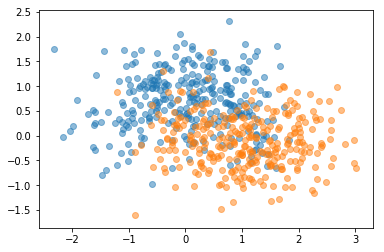

In [2]:
X, y = make_moons(n_samples=600, shuffle=True, noise=0.5, random_state=40)

plt.scatter(X[y == 0, 0], X[y == 0, 1], alpha=0.5)
plt.scatter(X[y == 1, 0], X[y == 1, 1], alpha=0.5)
plt.show()

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=40 )

A simple model can be fitted to the data and the model evaluated on the test data.

In [3]:
model_simp = DecisionTreeClassifier()
model_simp.fit(X_train, y_train)

print classification_report(y_test, model_simp.predict(X_test))

             precision    recall  f1-score   support

          0       0.84      0.74      0.79       103
          1       0.75      0.85      0.80        95

avg / total       0.80      0.79      0.79       198



Fitting a more complex model results in smaller classification errors.

In [4]:
model_comp = XGBClassifier()
model_comp.fit(X_train, y_train)

print classification_report(y_test, model_comp.predict(X_test))

             precision    recall  f1-score   support

          0       0.91      0.78      0.84       103
          1       0.79      0.92      0.85        95

avg / total       0.85      0.84      0.84       198



The approach of Domingos is based on applying the simple model to the predictions for the classes of the complex model (on the training data) rather than the actual data. For example:

In [5]:
y_new = model_comp.predict(X_train)

model_simple2 = DecisionTreeClassifier()
model_simple2.fit(X_train, y_new)

print classification_report(y_test, model_simple2.predict(X_test))

             precision    recall  f1-score   support

          0       0.91      0.80      0.85       103
          1       0.81      0.92      0.86        95

avg / total       0.86      0.85      0.85       198



The idea is that the new simple model (here called _model_\__simple2_) produces errors much closer to the complex model (_model_\__complex_) than training a simple model on the original data (_model_\__simple_).

Domingos proposed approached (called the CMM meta-learning algorithm) is more complex as instead of re-training the simple model he suggests using a mixture of the original data and data with changed labels. This is generated by picking a random sample of the data, chaning their labels using the predictions of the complex model, and then added togehter the orginal data and the re-labelled sample.

In [6]:
# Function to pick random data points
def random_points(X, n, replace=False):
    random_ind = np.random.choice(X.shape[0], n, replace=replace)
    X_new = X[random_ind,:]
    return X_new

# Generate additional points
X_add = random_points(X_train, 300)

# Predict their classes using complex model
y_add = model_comp.predict(X_add)

# Add these points to training data
X_train_more =np.append(X_train, X_add, axis=0)
y_train_more =np.append(y_train, y_add, axis=0)

# Train simple model
model_simple3 = DecisionTreeClassifier()
model_simple3.fit(X_train_more, y_train_more)

print classification_report(y_test, model_simple3.predict(X_test))

             precision    recall  f1-score   support

          0       0.80      0.77      0.78       103
          1       0.76      0.79      0.77        95

avg / total       0.78      0.78      0.78       198



In this case re-labelling all the data provided a better result. Note, the examples above are slightly unfair as you should tune the hyperparameters for each model in order to find out the optimised errors.

## Why does this work?

At first it seems strange that this approach works. We are re-training the simple model with re-labelled data, so instead of feeding it the truth we are feeded it data which contains points that have been misclassified by the complex model.

By plotting both the orginal training data and the re-labelled training data we can gain insight into why this approach works.

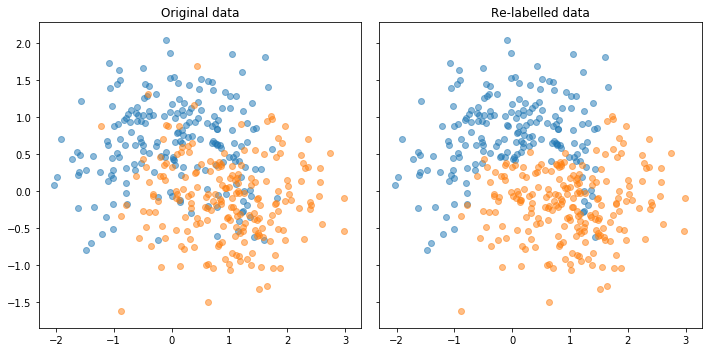

In [7]:
fig, (sub1, sub2) = plt.subplots(1, 2, sharey=True, figsize=(10,5))
sub1.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], alpha=0.5)
sub1.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], alpha=0.5)
sub1.set_title('Original data')

sub2.scatter(X_train[y_new == 0, 0], X_train[y_new == 0, 1], alpha=0.5)
sub2.scatter(X_train[y_new == 1, 0], X_train[y_new == 1, 1], alpha=0.5)
sub2.set_title('Re-labelled data')

plt.tight_layout()
plt.show()

In the re-labelled data alot of the noise has been removed and the classes are better seperated. It is, therefore, easier for the simple classifier to find a decision boundary that seperates the two classes. It is being guided by where the complex model thinks misclassifications are OK in order to produce an overall more accurate model.

A (not brilliant) analogy would be to consider two golders. A golf pro would be much better at hitting the ball towards the fairway than an amateur golfer on his own, but if the amateur watches were the pro aims for on a particular hole he might improve his own game.

## Visualising the tree

Following the scikit-learn documentation you can visualise the simple tree as follows.

In [8]:
import pydotplus
from IPython.display import Image
from sklearn.tree import export_graphviz

dot_data = export_graphviz(model_simple2, out_file=None, 
                         feature_names=["feature1", "feature2"],  
                         class_names=["class1", "class2"],  
                         filled=True, rounded=True,  
                         special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

ImportError: No module named pydotplus